In [1]:
import os
import cv2
import math
import random
import numpy as np
import shutil
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
main_dir = "Fin_Dataset/train"
images_dir = os.path.join(main_dir, "images")
labels_dir = os.path.join(main_dir, "labels")

augmented_images_dir = os.path.join(main_dir, "aug_images")
augmented_labels_dir = os.path.join(main_dir, "aug_labels")
os.makedirs(augmented_images_dir, exist_ok=True)
os.makedirs(augmented_labels_dir, exist_ok=True)

### Remove NULL images and labels

In [3]:
for label_file in os.listdir(labels_dir):
    label_path = os.path.join(labels_dir, label_file)
    
    # Check if the label file is empty
    if os.path.isfile(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()
        if not lines:
            os.remove(label_path)
            image_file = os.path.splitext(label_file)[0] + ".jpg"  # Change extension if needed
            image_path = os.path.join(images_dir, image_file)
            if os.path.exists(image_path):
                os.remove(image_path)
                    
print("Empty labels and their corresponding images have been removed.")

Empty labels and their corresponding images have been removed.


### Count the number of instances of each class

In [4]:
class_names = ['Cracks', 'Edge_Settling', 'No_Road', 'Potholes', 'Raveling', 'Rutting']
num_classes = len(class_names)

In [5]:
def count_instances_per_class(folder):
    """
    Count how many *instances* (i.e., bounding boxes) of each class exist
    in the YOLO annotation files inside `folder`.
    Returns a dictionary {class_id: count}.
    """
    counts = np.zeros(num_classes, dtype=int)
    for fname in os.listdir(folder):
        if fname.endswith('.txt'):
            with open(os.path.join(folder, fname), 'r') as f:
                lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 5:
                    cls = int(parts[0])
                    if 0 <= cls < num_classes:
                        counts[cls] += 1
    return {i: counts[i] for i in range(num_classes)}

### Performing Augmentation

In [6]:
def augment_image_and_labels(image, label_lines):
    """
    Applies both geometric and photometric augmentations to the image,
    and updates the YOLO-format labels accordingly.
    Returns the augmented image and updated label lines.
    """
    h, w = image.shape[:2]
    # Parse labels: YOLO format: class, cx, cy, bw, bh (normalized)
    bboxes = []
    for line in label_lines:
        parts = line.strip().split()
        cls = int(parts[0])
        cx, cy, bw, bh = map(float, parts[1:5])
        xmin = (cx - bw/2) * w
        ymin = (cy - bh/2) * h
        xmax = (cx + bw/2) * w
        ymax = (cy + bh/2) * h
        bboxes.append([cls, xmin, ymin, xmax, ymax])
    
    # Start with identity transformation (3x3)
    M_total = np.eye(3)
    
    # --- Geometric Transformations ---
    # Rotation
    if random.random() < 0.5:
        angle = random.uniform(-15, 15)
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)  # 2x3 matrix
        M_rot = np.vstack([M, [0, 0, 1]])  # Convert to 3x3
        M_total = M_rot @ M_total
        image = cv2.warpAffine(image, M, (w, h))
    
    # Shift & Scale
    if random.random() < 0.5:
        scale = random.uniform(0.9, 1.1)
        tx = random.randint(-20, 20)
        ty = random.randint(-20, 20)
        M_shift_scale = np.array([[scale, 0, tx],
                                  [0, scale, ty],
                                  [0,   0,   1]])
        M_total = M_shift_scale @ M_total
        image = cv2.warpAffine(image, M_shift_scale[:2, :], (w, h))
    
    # Horizontal Flip
    if random.random() < 0.5:
        image = cv2.flip(image, 1)
        M_flip = np.array([[-1, 0, w],
                           [0, 1, 0],
                           [0, 0, 1]])
        M_total = M_flip @ M_total

    # Update bounding boxes using composite transform
    new_label_lines = []
    for bbox in bboxes:
        cls, xmin, ymin, xmax, ymax = bbox
        pts = np.array([[xmin, ymin],
                        [xmax, ymin],
                        [xmax, ymax],
                        [xmin, ymax]], dtype=np.float32)
        ones = np.ones((pts.shape[0], 1), dtype=np.float32)
        pts_hom = np.hstack([pts, ones]).T  # shape (3,4)
        pts_trans = (M_total @ pts_hom).T  # shape (4,3)
        pts_trans = pts_trans[:, :2]  # take only (x,y)
        
        x_min_new = max(0, min(w, np.min(pts_trans[:,0])))
        y_min_new = max(0, min(h, np.min(pts_trans[:,1])))
        x_max_new = max(0, min(w, np.max(pts_trans[:,0])))
        y_max_new = max(0, min(h, np.max(pts_trans[:,1])))
        
        new_cx = (x_min_new + x_max_new) / 2.0 / w
        new_cy = (y_min_new + y_max_new) / 2.0 / h
        new_bw = (x_max_new - x_min_new) / w
        new_bh = (y_max_new - y_min_new) / h
        
        new_line = f"{cls} {new_cx:.6f} {new_cy:.6f} {new_bw:.6f} {new_bh:.6f}\n"
        new_label_lines.append(new_line)
        
    # --- Photometric Transformations ---
    # Brightness/Contrast
    if random.random() < 0.5:
        alpha = random.uniform(0.8, 1.2)
        beta = random.randint(-30, 30)
        image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    
    # Hue & Saturation adjustment (with overflow protection)
    if random.random() < 0.5:
        image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        h_delta = random.randint(-10, 10)
        s_mult = random.uniform(0.9, 1.1)
        image_hsv[:,:,0] = np.clip(image_hsv[:,:,0].astype(np.int16) + h_delta, 0, 179).astype(np.uint8)
        image_hsv[:,:,1] = np.clip(image_hsv[:,:,1].astype(np.float32) * s_mult, 0, 255).astype(np.uint8)
        image = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2BGR)
    
    # Gaussian Blur
    if random.random() < 0.3:
        ksize = random.choice([3, 5])
        image = cv2.GaussianBlur(image, (ksize, ksize), 0)
    
    # Sharpness Enhancement
    if random.random() < 0.3:
        kernel_sharp = np.array([[0, -1, 0],
                                 [-1, 5, -1],
                                 [0, -1, 0]])
        image = cv2.filter2D(image, -1, kernel_sharp)
    
    # Gamma Correction
    if random.random() < 0.3:
        gamma = random.uniform(0.8, 1.2)
        invGamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** invGamma) * 255 for i in range(256)]).astype("uint8")
        image = cv2.LUT(image, table)
    
    # CLAHE (on LAB L-channel)
    if random.random() < 0.3:
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        l = clahe.apply(l)
        lab = cv2.merge((l, a, b))
        image = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    
    return image, new_label_lines

In [7]:
original_data = []
for label_fname in os.listdir(labels_dir):
    if not label_fname.endswith('.txt'):
        continue
    label_path = os.path.join(labels_dir, label_fname)
    image_fname = os.path.splitext(label_fname)[0] + ".jpg"
    image_path = os.path.join(images_dir, image_fname)
    if not os.path.isfile(image_path):
        continue
    with open(label_path, 'r') as f:
        lines = f.readlines()
    classes_in_image = set()
    for line in lines:
        parts = line.strip().split()
        if len(parts) >= 5:
            classes_in_image.add(int(parts[0]))
    original_data.append({
        'image_path': image_path,
        'label_lines': lines,
        'classes': classes_in_image
    })

In [8]:
for data in original_data:
    img_fname = os.path.basename(data['image_path'])
    label_fname = os.path.splitext(img_fname)[0] + ".txt"
    target_img_path = os.path.join(augmented_images_dir, img_fname)
    target_label_path = os.path.join(augmented_labels_dir, label_fname)
    if not os.path.exists(target_img_path):
        shutil.copy2(data['image_path'], target_img_path)
    if not os.path.exists(target_label_path):
        with open(target_label_path, 'w') as f:
            f.writelines(data['label_lines'])

In [9]:
original_counts = count_instances_per_class(labels_dir)
print("Original image counts per class:", original_counts)

total_target_instances = 14000  # or any total desired number of instances
target_per_class = total_target_instances // num_classes
print("Target images per class (T):", target_per_class)

current_counts = count_instances_per_class(augmented_labels_dir)
print("Current image counts per class (in augmented folder):", current_counts)

deficits = {i: max(0, target_per_class - current_counts[i]) for i in range(num_classes)}
print("Initial deficits (x_i) per class:", deficits)

Original image counts per class: {0: np.int64(1415), 1: np.int64(63), 2: np.int64(127), 3: np.int64(442), 4: np.int64(3757), 5: np.int64(77)}
Target images per class (T): 2333
Current image counts per class (in augmented folder): {0: np.int64(1415), 1: np.int64(63), 2: np.int64(127), 3: np.int64(442), 4: np.int64(3757), 5: np.int64(77)}
Initial deficits (x_i) per class: {0: np.int64(918), 1: np.int64(2270), 2: np.int64(2206), 3: np.int64(1891), 4: 0, 5: np.int64(2256)}


In [15]:
aug_index = 0  # for naming augmented files
iteration = 0
while any(deficits[i] > 0 for i in range(num_classes)):
    iteration += 1
    progress = False
    # Randomize the order of original images for variety.
    random.shuffle(original_data)
    for data in original_data:
        # Check if this image contains at least one underrepresented class.
        if any(deficits[cls] > 0 for cls in data['classes']):
            # Read the original image (always start from the original)
            orig_img = cv2.imread(data['image_path'])
            if orig_img is None:
                continue
            aug_img, aug_label_lines = augment_image_and_labels(orig_img, data['label_lines'])
            # Save augmented image and labels
            base_name = os.path.splitext(os.path.basename(data['image_path']))[0]
            aug_img_fname = f"{base_name}_aug{aug_index}.jpg"
            aug_label_fname = f"{base_name}_aug{aug_index}.txt"
            cv2.imwrite(os.path.join(augmented_images_dir, aug_img_fname), aug_img)
            with open(os.path.join(augmented_labels_dir, aug_label_fname), "w") as f:
                f.writelines(aug_label_lines)
            aug_index += 1
            progress = True
            
            # For each class present in this augmented image, update counts if deficit > 0.
            for cls in data['classes']:
                if deficits[cls] > 0:
                    current_counts[cls] += 1
                    deficits[cls] = max(0, target_per_class - current_counts[cls])
            print(f"Augmented {aug_img_fname} contributed for classes {data['classes']}. Updated deficits: {deficits}")
            
            # If all deficits are cleared, break out.
            if all(deficits[i] == 0 for i in range(num_classes)):
                break
    if not progress:
        print("No progress in this pass; breaking out to avoid infinite loop.")
        break

print("Final counts after augmentation:", current_counts)
print("Final deficits:", deficits)

Final counts after augmentation: {0: np.int64(2333), 1: np.int64(2333), 2: np.int64(2333), 3: np.int64(2333), 4: np.int64(3757), 5: np.int64(2333)}
Final deficits: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}


In [16]:
def count_class_instances_from_dir(labels_dir, num_classes):
    class_counts = np.zeros(num_classes, dtype=int)

    for label_file in os.listdir(labels_dir):
        label_path = os.path.join(labels_dir, label_file)

        if os.path.isfile(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()

            for line in lines:
                class_id = int(line.split()[0])
                class_counts[class_id] += 1

    return {i: count for i, count in enumerate(class_counts)}

def plot_class_distribution_from_dirs(original_labels_dir, augmented_labels_dir, class_names):
    num_classes = len(class_names)

    # Count instances from original and augmented directories
    original_counts = count_class_instances_from_dir(original_labels_dir, num_classes)
    augmented_counts = count_class_instances_from_dir(augmented_labels_dir, num_classes)

    indices = np.arange(num_classes)
    width = 0.35

    original_values = [original_counts.get(i, 0) for i in range(num_classes)]
    augmented_values = [augmented_counts.get(i, 0) for i in range(num_classes)]

    plt.figure(figsize=(12, 6))
    bars1 = plt.bar(indices - width/2, original_values, width, label='Original', color='skyblue', edgecolor='black')
    bars2 = plt.bar(indices + width/2, augmented_values, width, label='Augmented', color='orange', edgecolor='black')

    plt.title("Image Instance Distribution per Class", fontsize=16)
    plt.xlabel("Class", fontsize=12)
    plt.ylabel("Number of Instances", fontsize=12)
    plt.xticks(indices, class_names, rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()

    # Annotate bar heights
    for bars in [bars1, bars2]:
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, int(yval),
                     ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

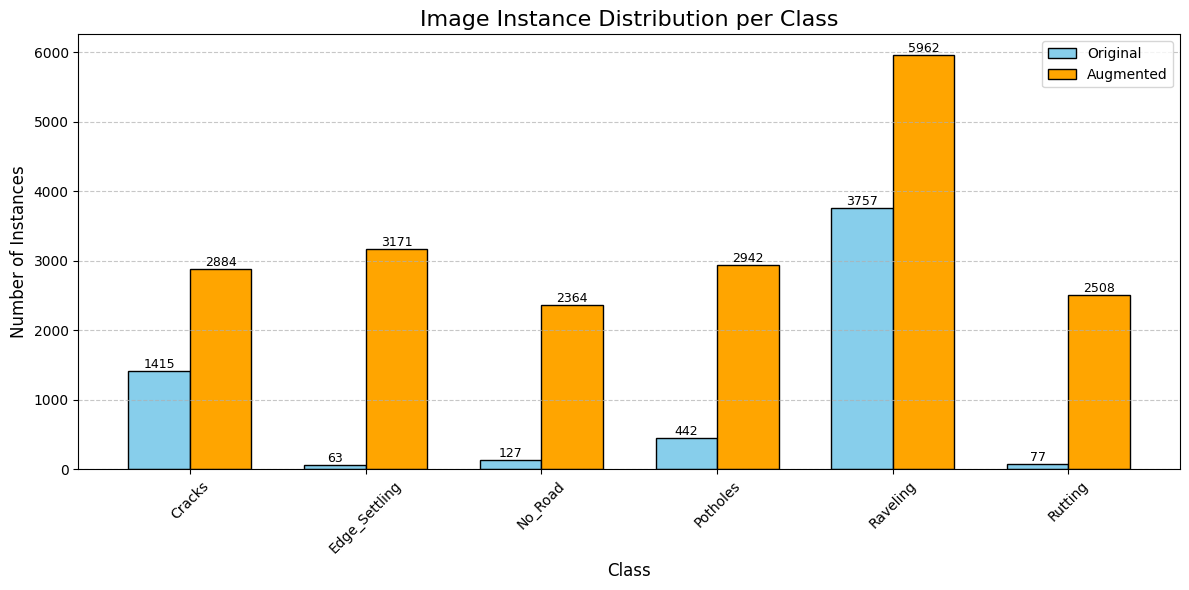

In [17]:
plot_class_distribution_from_dirs(labels_dir, augmented_labels_dir, class_names)